In [9]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [26]:
def nms_pytorch(P : torch.tensor, P_classes: list, class_hierachy: dict, thresh_score: float, thresh_iou : float):
    """(***)
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        P: (tensor) The location preds for the image
            along with the class predscores, Shape: [num_boxes, 5].
        P_classes: (list) class of boxes
        class_hierachy: (dict) class -> class's parent
        thresh_score: (float) Predscore threshold
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """

    # we extract the confidence scores as well
    scores = P[:, 4]

    # (***) Select boxes with confidence threshold that exceed a threshold
    P = P[scores > thresh_score, :]
    new_classes = []
    for idx, _ in enumerate(scores > thresh_score):
        if _ :
            new_classes.append(P_classes[idx])
    P_classes = new_classes
    scores = P[:, 4]

    # we extract coordinates for every
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)

    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for
    # filtered prediction boxes
    keep = []

    while len(order) > 0:

        # extract the index of the
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break

        # select coordinates of BBoxes according to
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1

        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order)

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]

        # find the IoU of every prediction in P with S
        IoU = inter / union


        # Get highly overlapped boxes
        ho_mask = IoU > thresh_iou
        ho_order = order[ho_mask]

        find_parent = False
        # Add to keep list
        for ho_idx in ho_order:
            # (***) Same class -> remove lower score -> just ignore it
            if P_classes[ho_idx] == P_classes[idx]:
                continue
            # (***) If S is parent class of P[ho_idx] -> remove S & add its child
            if class_hierachy[P_classes[ho_idx]] == P_classes[idx]:
                keep.append(P[ho_idx])
                find_parent = True
                break
        # (***) Keep S if S is not parent of any other classes
        if not find_parent:
            keep.append(P[idx])

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]

    return keep

In [50]:
# Let P be the following
thresh_score=0.9
thresh_iou=0.7

P = torch.tensor([
    [1, 1, 3, 3, 0.95],
    [1, 1, 3, 4, 0.93],
    [1, 0.9, 3.6, 3, 0.98],
    [1, 0.9, 3.5, 3, 0.97]
])

P_classes = ["apple", "apple", "fruit", "apple"]

class_hierachy = {"apple": "fruit", "orange":"fruit", "fruit":"fruit"}

In [51]:
filtered_boxes = nms_pytorch(P, P_classes = P_classes, class_hierachy=class_hierachy, thresh_score=thresh_score, thresh_iou=thresh_iou)
filtered_boxes

[tensor([1.0000, 1.0000, 3.0000, 3.0000, 0.9500])]

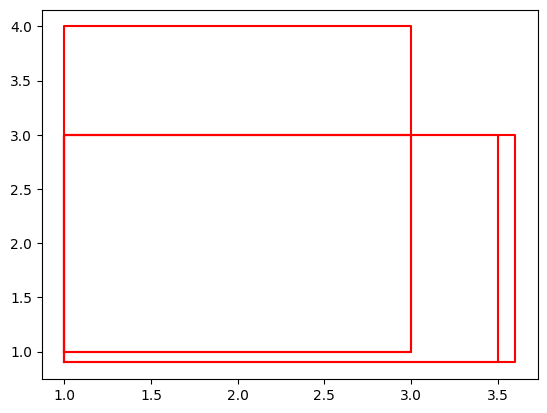

In [52]:
# Before fitering
fig, ax = plt.subplots()

for box in P:
    xs = [box[0], box[2], box[2], box[0], box[0]]
    ys = [box[1], box[1], box[3], box[3], box[1]]
    ax.plot(xs, ys, color="red")
plt.show()

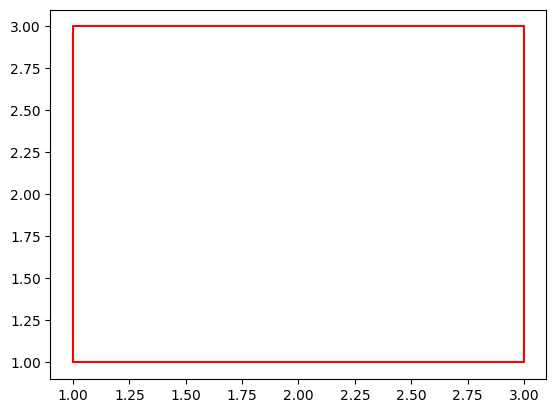

In [53]:
# After filtering
fig, ax = plt.subplots()

for box in filtered_boxes:
    xs = [box[0], box[2], box[2], box[0], box[0]]
    ys = [box[1], box[1], box[3], box[3], box[1]]
    ax.plot(xs, ys, color="red")
# Coordinates of rectangle vertices
# in clockwise order
#display plot
plt.show()